<a href="https://colab.research.google.com/github/mfpole/Cost-of-Living-Index-Analysis-over-2010-2019/blob/master/Cost_of_Living_Index_Analysis_over_2010_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from bs4 import BeautifulSoup
from requests import get
import pandas as pd

dataRaw = pd.DataFrame()

for year in range(2010,2021):
  year = str(year)
  mta = get('https://www.numbeo.com/cost-of-living/rankings.jsp?title='+year)
  mta.raise_for_status()
  #print(mta.text)
  mta_HTML = BeautifulSoup(mta.text)
  #print(mta_HTML)
  #wrapper = mta_HTML.findAll('td', class_="cityOrCountryInIndicesTable")
  #wrapper
  table = mta_HTML.find('table', id = 't2')
  table_rows = table.find_all('tr')

  table_columns = table_rows[0].text.split('\n')[1:9] 
  table_columns.append('Year')
  #table_rows[0].text.split('\n')[1:9]
  l = []
  for tr in table_rows[1:]:
      td = tr.find_all('td')
      row = [tr.text for tr in td[0:9]]
      row.append(year)
      l.append(row)
  dataNew = pd.DataFrame(l, columns=table_columns)

  dataRaw = dataRaw.append(dataNew)


Let's format all the numbers to numeric types so that we can process them as such later

In [3]:
data = dataRaw.copy()
data = data.astype({'Cost of Living Index': 'float64','Rent Index':'float64','Cost of Living Plus Rent Index':'float64','Groceries Index':'float64','Restaurant Price Index':'float64','Local Purchasing Power Index':'float64','Year':'float64'})
print(data.dtypes)


Rank                               object
City                               object
Cost of Living Index              float64
Rent Index                        float64
Cost of Living Plus Rent Index    float64
Groceries Index                   float64
Restaurant Price Index            float64
Local Purchasing Power Index      float64
Year                              float64
dtype: object


In [4]:
#There are US States that have states so I need to control the flow to separate the county 


#Lets test a way to find the United States 
data.loc[data['City'].str.endswith("States")]




,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Year
19,,"Tampa, FL, United States",109.64,39.98,78.51,99.16,66.77,88.87,2010.0
22,,"Columbus, OH, United States",104.69,42.63,76.96,97.75,66.82,93.68,2010.0
25,,"Portland, OR, United States",102.90,46.57,77.73,94.37,72.67,122.67,2010.0
26,,"Atlanta, GA, United States",100.99,40.66,74.03,93.88,87.19,79.58,2010.0
28,,"Seattle, WA, United States",100.33,49.85,77.77,104.88,107.68,133.93,2010.0
...,...,...,...,...,...,...,...,...,...
179,,"Detroit, MI, United States",63.85,37.80,51.39,63.33,58.91,78.58,2020.0
192,,"Cincinnati, OH, United States",61.64,33.99,48.42,56.83,60.54,131.81,2020.0
196,,"Boise, ID, United States",60.71,34.47,48.16,50.39,69.52,99.05,2020.0
198,,"Little Rock, AR, United States",59.76,26.39,43.80,51.17,68.05,124.54,2020.0


In [5]:
data.loc[data['City'].str.endswith("States")]

#Let's see if everything has 3 items in the US and 2 items internationally
data['USorOther'] = data['City'].str.endswith("States")
data['CitySplit'] = data['City'].str.split(',')
data['CityCheck'] =  data['CitySplit'].str.len()

#We can group by USorOther to see if there are any anomalies 
data.groupby(by='USorOther')['CityCheck'].max()

#USorOther
#False    3
#True     3
#Name: CityCheck, dtype: int64

#There are some other countries with 3 splits so lets look at the rows where CityCheck is 3
Other3CommaCountries = pd.DataFrame(data.loc[(data['CityCheck'] == 3) & (data['USorOther']==False)])
Other3CommaCountries

#    Rank                           City  ... CityCheck USorOther
#134                 Nanaimo, BC, Canada  ...         3     False
#154              Lethbridge, AB, Canada  ...         3     False
#52               Lethbridge, AB, Canada  ...         3     False
#152                 Nanaimo, BC, Canada  ...         3     False
#371       Cyberjaya, Selangor, Malaysia  ...         3     False
#218                 Nanaimo, BC, Canada  ...         3     False
#[6 rows x 12 columns]

#There are some misformatted data points in Canada and Malasyia... let's remove them. 


#This will select the opposite of the previous check
cleanData = data.loc[~((data['CityCheck'] == 3) & (data['USorOther']==False))]

#Let's check to see if that worked 
cleanData.groupby(by='USorOther')['CityCheck'].max()

#USorOther
#False    2
#True     3
#Name: CityCheck, dtype: int64

#Wow. Nice.


USorOther
False    2
True     3
Name: CityCheck, dtype: int64

With the verification and cleanup of my City column done, I can start adding more columns such as City Name, Country, and US State. Because there are the US Cities with 3 entries and other countries with 2 entries I can break them apart with an apply() function. 

data.loc[data['City'].str.endswith("States")]['CitySplit'].str[2]

Running the above shows me that for US data, the Country is in the third position. But for other countries, Country is in the second position. This means that I will have to create an apply() function that will pass three columns at once in two different configurations. 

I will pass the columns as City, Country, US State. For non-US countries I will pass an empty string as the value. 



In [0]:
#Define the apply function to return the series with 3 values 
def countryStateCitySplit(value):
  try: 
    if value.endswith("States"):
      value = value.split(', ')
      return pd.Series([value[0], value[2],value[1]])
    else: 
      value = value.split(', ')
      return pd.Series([value[0], value[1],""])
  except Exception as e: 
     return e, value
       


Lets test the above function with some non looped values (us and non-us)


In [31]:
USValues = cleanData.loc[cleanData['City'].str.endswith('States')]
testValue = USValues.iloc[4]['City']
countryStateCitySplit(testValue)
#testValueList = testValue.split(',')
#print(testValueList[1])

#otherValue = cleanData.iloc[1]['City']
#countryStateCitySplit(otherValue)











0          Seattle
1    United States
2               WA
dtype: object

Test values seem to be working! Now lets run it!

In [32]:
cleanData2 = cleanData.copy()
cleanData2[['CityName', 'Country', 'US State']] = cleanData['City'].apply(countryStateCitySplit)
cleanData2


,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Year,USorOther,CitySplit,CityCheck,CityName,Country,US State
0,,"Stavanger, Norway",169.20,103.02,139.63,190.35,220.64,50.21,2010.0,False,"[Stavanger, Norway]",2,Stavanger,Norway,
1,,"Oslo, Norway",152.85,71.02,116.28,133.02,142.31,77.84,2010.0,False,"[Oslo, Norway]",2,Oslo,Norway,
2,,"Breda, Netherlands",139.70,54.03,101.42,80.63,124.83,81.82,2010.0,False,"[Breda, Netherlands]",2,Breda,Netherlands,
3,,"Copenhagen, Denmark",138.91,78.63,111.97,116.60,159.09,91.30,2010.0,False,"[Copenhagen, Denmark]",2,Copenhagen,Denmark,
4,,"Zurich, Switzerland",132.03,99.23,117.37,102.52,157.47,111.08,2010.0,False,"[Zurich, Switzerland]",2,Zurich,Switzerland,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,,"Karachi, Pakistan",23.07,4.57,14.22,20.03,19.20,29.27,2020.0,False,"[Karachi, Pakistan]",2,Karachi,Pakistan,
436,,"Islamabad, Pakistan",22.95,6.00,14.84,22.23,17.22,30.28,2020.0,False,"[Islamabad, Pakistan]",2,Islamabad,Pakistan,
437,,"Vijayawada, India",22.31,5.09,14.07,23.04,13.19,47.38,2020.0,False,"[Vijayawada, India]",2,Vijayawada,India,
438,,"Visakhapatnam, India",21.09,4.11,12.97,21.43,13.52,52.04,2020.0,False,"[Visakhapatnam, India]",2,Visakhapatnam,India,


Now I have a column for CityName, Country, and US State (if US otherwise an empty string). 

Another thing to consider is that the rows for each year don't always match up. I think that will create issues in getting the mean per country so let's clean it up again so that we are only getting the cities that are in each data set. We can check by only selecting the cities that have 11 values (2010-2020)

In [0]:
cleanData3 = cleanData2.copy()

In [26]:
#There was an error running this where I had added some additional rows by accident 
#cleanData3.loc[cleanData3['CityName']=='Zagreb'].groupby(by=['City','Year']).count()
cityGroupCount = cleanData3.groupby(by=['City']).count()
cityGroupCount

,Rank,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Year,USorOther,CitySplit,CityCheck,CityName,Country,US State
City,,,,,,,,,,,,,,
"'afrin, Syria",1,1,1,1,1,1,1,1,1,1,1,1,1,1
"Aachen, Germany",8,8,8,8,8,8,8,8,8,8,8,8,8,8
"Aalborg, Denmark",7,7,7,7,7,7,7,7,7,7,7,7,7,7
"Abbotsford, Canada",2,2,2,2,2,2,2,2,2,2,2,2,2,2
"Aberdeen, United Kingdom",9,9,9,9,9,9,9,9,9,9,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zagreb, Croatia",11,11,11,11,11,11,11,11,11,11,11,11,11,11
"Zaporizhzhya, Ukraine",1,1,1,1,1,1,1,1,1,1,1,1,1,1
"Zaragoza (Saragossa), Spain",5,5,5,5,5,5,5,5,5,5,5,5,5,5


Now that we have seen that some cities are in the data set 11 times, let's try selecting only them to see how many we have 



In [77]:
goodCities = cityGroupCount.loc[cityGroupCount['Rank']==11]
len(goodCities)

83

There are 83 cities that have data for all 11 years, let's use these as our main data set! 

In [79]:
goodCitiesList = list(goodCities.index)
print(goodCitiesList)
print(len(goodCitiesList))



['Abu Dhabi, United Arab Emirates', 'Ahmedabad, India', 'Amman, Jordan', 'Amsterdam, Netherlands', 'Athens, Greece', 'Austin, TX, United States', 'Bangalore, India', 'Bangkok, Thailand', 'Banja Luka, Bosnia And Herzegovina', 'Barcelona, Spain', 'Beijing, China', 'Belgrade, Serbia', 'Berlin, Germany', 'Bogota, Colombia', 'Boston, MA, United States', 'Brussels, Belgium', 'Bucharest, Romania', 'Budapest, Hungary', 'Buenos Aires, Argentina', 'Chennai, India', 'Cluj-Napoca, Romania', 'Copenhagen, Denmark', 'Delhi, India', 'Dubai, United Arab Emirates', 'Dublin, Ireland', 'Edmonton, Canada', 'Frankfurt, Germany', 'Geneva, Switzerland', 'Guadalajara, Mexico', 'Helsinki, Finland', 'Hong Kong, Hong Kong', 'Hyderabad, India', 'Istanbul, Turkey', 'Jakarta, Indonesia', 'Johannesburg, South Africa', 'Kiev (Kyiv), Ukraine', 'Kolkata, India', 'Kuala Lumpur, Malaysia', 'Leeds, United Kingdom', 'Lisbon, Portugal', 'Ljubljana, Slovenia', 'London, United Kingdom', 'Lyon, France', 'Madrid, Spain', 'Medell

We can save the index of our filtered df as a list to filter the original data set on (using the pandas series function "isin()"

In [81]:
cleanData4 = cleanData3.loc[cleanData3['City'].isin(goodCitiesList)]
cleanData4

,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Year,USorOther,CitySplit,CityCheck,CityName,Country,US State
0,,"Stavanger, Norway",169.20,103.02,139.63,190.35,220.64,50.21,2010.0,False,"[Stavanger, Norway]",2,Stavanger,Norway,
1,,"Oslo, Norway",152.85,71.02,116.28,133.02,142.31,77.84,2010.0,False,"[Oslo, Norway]",2,Oslo,Norway,
3,,"Copenhagen, Denmark",138.91,78.63,111.97,116.60,159.09,91.30,2010.0,False,"[Copenhagen, Denmark]",2,Copenhagen,Denmark,
4,,"Zurich, Switzerland",132.03,99.23,117.37,102.52,157.47,111.08,2010.0,False,"[Zurich, Switzerland]",2,Zurich,Switzerland,
5,,"Paris, France",130.30,80.51,108.05,115.25,123.95,64.19,2010.0,False,"[Paris, France]",2,Paris,France,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,,"Bangalore, India",27.22,8.89,18.45,27.20,20.76,68.14,2020.0,False,"[Bangalore, India]",2,Bangalore,India,
415,,"Ahmedabad, India",25.58,7.22,16.79,25.90,17.72,38.52,2020.0,False,"[Ahmedabad, India]",2,Ahmedabad,India,
417,,"Chennai, India",25.32,6.59,16.36,25.95,15.87,53.06,2020.0,False,"[Chennai, India]",2,Chennai,India,
418,,"Hyderabad, India",25.32,6.41,16.27,26.25,16.68,57.90,2020.0,False,"[Hyderabad, India]",2,Hyderabad,India,


The resulting data set is 913 rows which happens to be 11 * 83 (the amount of cities). That seems right! Let's start analysing this cleaned up data set. 

Question 1 is what countries have the highest/lowest mean of each index. For this we can start by just looking at the most recent data set for the Cost of Living Index

In [68]:
highestCostOfLiving = cleanData4.loc[cleanData4['Year']==2020][['Country','Cost of Living Index','Rent Index']]
highestCostOfLiving = highestCostOfLiving.groupby(by=['Country']).mean()
highestCostOfLiving


,Cost of Living Index,Rent Index
Country,,
Argentina,34.580000,9.050000
Australia,75.740000,46.565000
Austria,65.640000,30.810000
Belarus,36.200000,11.830000
Belgium,72.330000,30.100000
Bosnia And Herzegovina,36.700000,7.660000
Brazil,42.700000,14.240000
Bulgaria,39.960000,13.280000
Canada,71.803333,36.006667


In [60]:
#since I'm looking at by year I don't really care as much if some cities are not in all 11 years 
#statesByYear = cleanData3.loc[cleanData3['Country']=='United States'].pivot(index='CityName', columns = 'Year', values = ['Cost of Living Index','Rent Index'])

#I am getting a duplicate record error 


duplicates = cleanData3.loc[(cleanData3.duplicated(subset=['CityName','Year'], keep=False))&(cleanData3['Country'] == 'United States')] 
#USduplicates = cleanData3.loc[(cleanData3['Country'] == 'United States')  & duplicates]
duplicates

#type(cleanData3)

#
#statesByYearDuplicates

,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Year,USorOther,CitySplit,CityCheck,CityName,Country,US State
87,,"San Jose, CA, United States",81.88,65.10,75.86,84.01,59.31,125.59,2011.0,True,"[San Jose, CA, United States]",3,San Jose,United States,CA
79,,"San Jose, CA, United States",94.11,73.36,86.64,82.33,82.04,113.13,2012.0,True,"[San Jose, CA, United States]",3,San Jose,United States,CA
134,,"San Jose, CA, United States",87.42,79.13,83.44,82.46,84.44,126.65,2013.0,True,"[San Jose, CA, United States]",3,San Jose,United States,CA
149,,"Saint Petersburg, FL, United States",88.71,37.78,63.97,100.46,64.70,84.56,2014.0,True,"[Saint Petersburg, FL, United States]",3,Saint Petersburg,United States,FL
159,,"San Jose, CA, United States",87.39,72.12,79.97,96.06,76.20,129.95,2014.0,True,"[San Jose, CA, United States]",3,San Jose,United States,CA
246,,"Birmingham, AL, United States",71.18,36.42,54.29,75.74,64.13,170.38,2014.0,True,"[Birmingham, AL, United States]",3,Birmingham,United States,AL
109,,"San Jose, CA, United States",85.87,77.57,81.82,96.48,72.08,143.23,2015.0,True,"[San Jose, CA, United States]",3,San Jose,United States,CA
103,,"Naples, FL, United States",77.50,33.52,56.37,81.77,69.58,139.76,2016.0,True,"[Naples, FL, United States]",3,Naples,United States,FL
106,,"San Jose, CA, United States",77.11,80.71,78.84,81.00,70.26,169.92,2016.0,True,"[San Jose, CA, United States]",3,San Jose,United States,CA
158,,"Vancouver, WA, United States",72.67,31.10,52.69,76.76,58.86,152.22,2016.0,True,"[Vancouver, WA, United States]",3,Vancouver,United States,WA


My duplicate values were being caused by cities with the same City Name (i.e. London, Ontario).. Since both Portland Maine and Portland Oregon are in the data set, I should use a column created by the City and State instead!!


In [0]:
cleanData3US = cleanData3.loc[cleanData3['Country']=='United States'].copy()
cleanData3US['City,State'] = cleanData3US['CityName'] + ', ' + cleanData3US['US State']
statesByYear = cleanData3US.pivot(index='City,State', columns = 'Year', values = ['Cost of Living Index','Rent Index'])
statesByYear

Hmm this is a bit crazy actually. I'm not too interested in Akron. 

In [87]:
cleanData4US = cleanData4.loc[cleanData4['Country']=='United States'].copy()
cleanData4US['City,State'] = cleanData4US['CityName'] + ', ' + cleanData4US['US State']
statesByYear = cleanData4US.pivot(index='City,State', columns = 'Year', values = ['Cost of Living Index','Rent Index'])


KeyError: ignored

This is an interesting pivot table! See how Seattle and San Francisco really jump up against New York in the mid 2010's? It's also interesting to see that the Cost of Living in Seattle otherwise is going down, I wonder if this is because of cheaper distribution costs...

Text(0, 0.5, 'Rent Index')

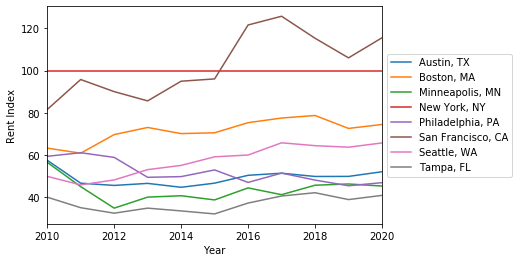

In [100]:
import matplotlib.pyplot as plt


#cleanData4US[['City,State','Year','Rent Index']].plot(x='Year', y = 'City,State')
statesByYear = cleanData4US.pivot(index='Year', columns = 'City,State', values = 'Rent Index').plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Rent Index')


